In [1]:
import time
import numpy as np
from copy import copy

# First of all we import the Flatland rail environment
from rail_env import RailEnv
from observations import TreeObsForRailEnvAug, feat_order

from flatland.envs.rail_generators import sparse_rail_generator
from flatland.envs.schedule_generators import sparse_schedule_generator
# We also include a renderer because we want to visualize what is going on in the environment
from flatland.utils.rendertools import RenderTool, AgentRenderVariant
from flatland.envs.malfunction_generators import malfunction_from_params
from flatland.envs.agent_utils import RailAgentStatus

from collections import defaultdict

from scipy.ndimage import rotate
from scipy.sparse.csr import csr_matrix
from scipy.sparse import coo_matrix
import scipy.sparse as sp

from gcn import GCN, args
from multihead_attention import MultiHeadAttention

import networkx as nx

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import torch
device = torch.device('cuda')

In [2]:
width = 100  # With of map
height = 100  # Height of map
nr_trains = 50  # Number of trains that have an assigned task in the env
cities_in_map = 20  # Number of cities where agents can start or end
seed = 25  # Random seed
grid_distribution_of_cities = False  # Type of city distribution, if False cities are randomly placed
max_rails_between_cities = 2  # Max number of tracks allowed between cities. This is number of entry point to a city
max_rail_in_cities = 6  # Max number of parallel tracks within a city, representing a realistic trainstation


In [3]:
rail_generator = sparse_rail_generator(max_num_cities=cities_in_map,
                                       seed=seed,
                                       grid_mode=grid_distribution_of_cities,
                                       max_rails_between_cities=max_rails_between_cities,
                                       max_rails_in_city=max_rail_in_cities,
                                       )

In [4]:
# The schedule generator can make very basic schedules with a start point, end point and a speed profile for each agent.
# The speed profiles can be adjusted directly as well as shown later on. We start by introducing a statistical
# distribution of speed profiles

# Different agent types (trains) with different speeds.
speed_ration_map = {1.: 0.25,  # Fast passenger train
                    1. / 2.: 0.25,  # Fast freight train
                    1. / 3.: 0.25,  # Slow commuter train
                    1. / 4.: 0.25}  # Slow freight train

In [5]:
# We can now initiate the schedule generator with the given speed profiles
schedule_generator = sparse_schedule_generator(speed_ration_map)

In [6]:
# We can furthermore pass stochastic data to the RailEnv constructor which will allow for stochastic malfunctions
# during an episode.

stochastic_data = {'prop_malfunction': 0.3,  # Percentage of defective agents
                   'malfunction_rate': 30,  # Rate of malfunction occurence
                   'min_duration': 3,  # Minimal duration of malfunction
                   'max_duration': 20  # Max duration of malfunction
                   }

In [7]:
# Tree predictor
max_depth = 3
RAD = 5
observation_builder = TreeObsForRailEnvAug(max_depth=max_depth, RAD=RAD)

In [8]:
# Custom observation builder with predictor, uncomment line below if you want to try this one
# observation_builder = TreeObsForRailEnv(max_depth=2, predictor=ShortestPathPredictorForRailEnv())

# Construct the enviornment with the given observation, generataors, predictors, and stochastic data
env = RailEnv(width=width,
              height=height,
              rail_generator=rail_generator,
              schedule_generator=schedule_generator,
              number_of_agents=nr_trains,
              malfunction_generator_and_process_data=malfunction_from_params(stochastic_data),
              obs_builder_object=observation_builder,
              remove_agents_at_target=True  # Removes agents at the end of their journey to make space for others
             )


In [9]:
def my_controller():
    """
    You are supposed to write this controller
    """
    _action = {}
    for _idx in range(env.number_of_agents):
        _action[_idx] = np.random.randint(0, 5)
    return _action

In [10]:
_, _ = env.reset()

In [11]:
for i in range(50):
    obs, all_rewards, done, info = env.step(my_controller())

### Utilities

In [12]:

def scale(a, m, M):
    return (a-m)/(M-m)

def rotate_map(maps, dir_):
    rot_deg = (dir_-4)*90
    if rot_deg == -360: rot_deg = 0
    if rot_deg != 0:
        maps = rotate(maps, rot_deg)
    return maps

def get_rotation_dict():
    xx, yy = np.meshgrid(np.arange(11), np.arange(11))
    idx_mat = yy*(2*RAD+1) + xx
    rotation_dict = dict()
    for dir_ in range(0, 4):
        rotation_dict[dir_] = rotate_map(idx_mat, dir_).ravel()
    return rotation_dict

def get_feature_matrix(handle):
    
    feature_matrix = np.zeros(((2*RAD+1)**2, len(feat_order)))

    dist_min_to_target_index = feat_order['dist_min_to_target']
    try:
        cy, cx = env.agents[handle].position
    except TypeError:
        cy, cx = env.agents[handle].initial_position
    dist_scalar = env.obs_builder.search_obs[handle].pop('distance_scalar')
    dist_min, dist_max = 0, 0
    for node_id, node in env.obs_builder.search_obs[handle].items():
        tot_dist, py, px, dir_ = [int(el) for el in node_id.split('_')]
        y, x = py-cy+RAD, px-cx+RAD
        if (y > -1) and y < (2*RAD + 1) and (x > -1) and (x < 2*RAD + 1):
            idx = y*(2*RAD + 1) + x
            for ch, el in enumerate(node):
                if el is not None:
                    if ch == dist_min_to_target_index:
                        el = (dist_scalar-el)/dist_scalar
                        dist_max = max(dist_max, el)
                    feature_matrix[idx, ch] = el

    feature_matrix[:, dist_min_to_target_index] = scale(feature_matrix[:, dist_min_to_target_index], dist_min, dist_max)
    
    return feature_matrix[rotation_dict[env.agents[handle].direction]]

def get_adjacency_matrix(handle):

    try:
        cy, cx = env.agents[handle].position
    except TypeError:
        cy, cx = env.agents[handle].initial_position

    A = np.zeros(((2*RAD+1)**2, (2*RAD+1)**2))

    for branch_id, branch in env.obs_builder.search_branches[handle].items():
        _, py, px, _ = [int(el) for el in branch_id.split('_')]
        y, x = py-cy+RAD, px-cx+RAD
        explore_branch = False
        if ((y > -1) and y < (2*RAD + 1) and (x > -1) and (x < 2*RAD + 1)):
            explore_branch = True
            idx = y*(2*RAD+1) + x
        if explore_branch:
            for sub_branch in branch:
                idxs = []
                for py, px in sub_branch:
                    y, x = py-cy+RAD, px-cx+RAD
                    if (y > -1) and y < (2*RAD + 1) and (x > -1) and (x < 2*RAD + 1):
                        idx = y*(2*RAD+1) + x
                        idxs.append(idx)
                    else:
                        explore_branch = False
                    if explore_branch == False:
                        break
                A_row = np.zeros((2*RAD+1)**2)
                A_row[idxs] = True
                A[idxs, :] += A_row

    return (A[rotation_dict[env.agents[handle].direction]]>0).astype(float)

def build_graph():
    graph = dict()
    for handle in range(env.number_of_agents):
        if not env.agents in (RailAgentStatus.DONE, RailAgentStatus.DONE_REMOVED):
            nodes = get_feature_matrix(handle)
            edges = get_adjacency_matrix(handle)
            graph[handle] = (nodes, edges)
    return graph

def build_tensors():
    all_features = torch.zeros((env.number_of_agents, (2*RAD+1)**2, len(feat_order))).float()
    all_supports = torch.zeros((env.number_of_agents, (2*RAD+1)**2, (2*RAD+1)**2)).float()
    for handle, (features, adj) in graph.items():
        all_features[handle] = preprocess_features(features)
        all_supports[handle] = preprocess_adj(adj)
    return all_features, all_supports

def preprocess_features(features):
    """
    Row-normalize feature matrix
    """
    rowsum = features.sum(1) # get sum of each row, [2708, 1]
    r_inv = np.power(rowsum, -1).flatten() # 1/rowsum, [2708]
    r_inv[np.isinf(r_inv)] = 0. # zero inf data
    r_mat_inv = np.diag(r_inv) # sparse diagonal matrix, [2708, 2708]
    
    return torch.from_numpy(r_mat_inv.dot(features)).float() # D^-1:[2708, 2708]@X:[2708, 2708]

def preprocess_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = ((adj + np.eye(adj.shape[0])) > 0).astype('float')
    rowsum = np.array(adj.sum(1)) # D
    d_inv_sqrt = np.power(rowsum, -0.5).flatten() # D^-0.5
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = np.diag(d_inv_sqrt) # D^-0.5
    return torch.from_numpy(adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt)).float() # D^-0.5AD^0.5


rotation_dict = get_rotation_dict()

### Constructing Graph and Tensors

In [13]:
start = time.time()

graph = build_graph()
feature_tens, support_tens = build_tensors()

end = time.time()
print('{} second runtime'.format(round(end-start, 6)))


0.044882 second runtime


In [14]:
feature_tens.shape, support_tens.shape

(torch.Size([50, 121, 24]), torch.Size([50, 121, 121]))

In [41]:
handle = np.random.randint(env.number_of_agents)
print('handle: ', handle)
features, supports = graph[handle]

handle:  5


### Scaled inverse distance to target encoding

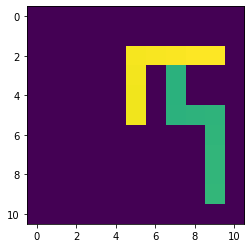

In [42]:
plt.imshow(features[:, feat_order['dist_min_to_target']].reshape((2*RAD+1, 2*RAD+1)))

handle:  18


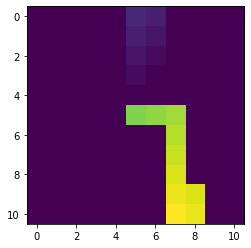

In [89]:
handle = np.random.randint(env.number_of_agents)
print('handle: ', handle)
features, supports = graph[handle]
plt.imshow(features[:, feat_order['dist_min_to_target']].reshape((2*RAD+1, 2*RAD+1)))

### There's a bug within the tree search, there should be a branch extending to the right, has to do with self.break_search???

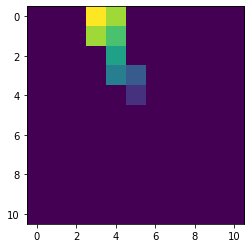

In [26]:
plt.imshow(features[:, feat_order['dist_min_to_target']].reshape((2*RAD+1, 2*RAD+1)))

### Search path(s) relative directions

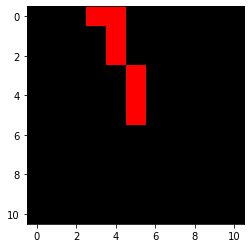

In [27]:
plt.imshow(features[:, [15,16,17]].reshape((2*RAD+1, 2*RAD+1, 3)))

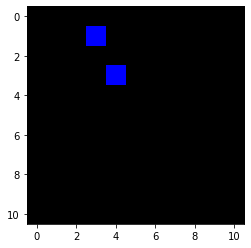

In [28]:
plt.imshow(features[:, [16,17,18]].reshape((2*RAD+1, 2*RAD+1, 3)))

### Feature Matrix

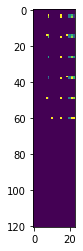

In [29]:
plt.imshow(features)

### Adjacency Matrix

In [30]:
supports

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

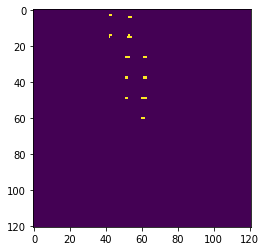

In [31]:
plt.imshow(supports)

### Set Graph Convolutional Network

In [28]:
feat_dim = len(feat_order)
net = GCN(feat_dim, args['hidden'], feat_dim)
net.to(device)

input dim: 24
output dim: 128
num_features_nonzero: 24


GCN(
  (layers): Sequential(
    (0): GraphConvolution()
    (1): GraphConvolution()
  )
)

In [29]:
feature_tens.shape, support_tens.shape

(torch.Size([50, 121, 24]), torch.Size([50, 121, 121]))

### Set Attention Layer

In [30]:
head_num = 8
attention_layer = MultiHeadAttention(args['hidden'], head_num)
attention_layer.to(device)

MultiHeadAttention(
  in_features=128, head_num=8, bias=True, activation=<function relu at 0x000001F36C268438>
  (linear_o): Linear(in_features=128, out_features=128, bias=True)
)

### Run 2-hop Graph Convolution over local neighborhood

In [44]:
start = time.time()

gcn_outs = net((feature_tens, support_tens))

end = time.time()
print('{} second runtime'.format(round(end-start, 6)))

0.015956 second runtime


In [56]:
central_idx = (2*RAD+1)*RAD + RAD
def get_central_tens(handle):
    cntrl_tens = gcn_outs[0][handle][central_idx]
    cntrl_tens = cntrl_tens.reshape((1, 1, args['hidden']))
    return cntrl_tens

def get_neighbor_tens(handle):
    nghbr_handles = env.obs_builder.neighbors[handle]
    is_dummy = True
    if nghbr_handles:
        is_dummy = False
        n_nghbrs = len(nghbr_handles)
        nghbr_tens = gcn_outs[0][nghbr_handles][list(range(n_nghbrs)), [(2*RAD+1)*RAD + RAD]*n_nghbrs].clone().detach().unsqueeze(0)
        return nghbr_tens, is_dummy
    else:
        dummy_tens = torch.zeros((1, 1, args['hidden'])).float().to(device)
        return dummy_tens, is_dummy


### Pull out Central Node

In [62]:
handle = 42
central_tens = get_central_tens(handle)
central_tens

tensor([[[1.2274, 0.0000, 0.0000, 0.0000, 1.7336, 1.4263, 0.0000, 2.6894,
          2.5562, 0.0000, 0.0000, 0.9684, 0.3831, 0.0000, 2.8499, 2.3040,
          0.4766, 1.8371, 1.1321, 0.6917, 0.0000, 0.0000, 0.0000, 0.0000,
          0.6848, 1.0157, 1.1985, 0.0000, 2.0613, 0.0000, 0.0000, 1.8653,
          0.0000, 0.0000, 2.9686, 0.6544, 1.4946, 0.0000, 0.3114, 0.0000,
          1.9276, 1.1475, 0.0000, 0.0000, 1.9709, 1.8327, 0.2897, 1.2341,
          2.5827, 0.0000, 0.0000, 1.6043, 0.0000, 0.0000, 2.8682, 1.5857,
          0.0000, 1.3112, 0.0000, 0.1039, 0.0000, 0.1337, 0.0000, 0.0000,
          1.9187, 0.0000, 4.1502, 0.0000, 0.0000, 2.8054, 0.0000, 0.0000,
          0.6546, 2.3590, 0.0000, 0.0000, 0.1570, 0.0000, 1.9027, 0.0000,
          0.0000, 0.0000, 0.6139, 0.0000, 5.1009, 0.0000, 1.4376, 0.0000,
          0.0000, 0.5813, 2.1270, 1.1713, 0.0000, 0.9748, 0.0000, 0.0000,
          0.1893, 0.0000, 0.0000, 0.0000, 2.7003, 0.0000, 0.0000, 0.0000,
          1.2417, 0.7222, 0.0000, 0.00

### Pull out neighbor central nodes, else construct dummy tensor

In [63]:
neighbor_tens, is_dummy_ = get_neighbor_tens(handle)
neighbor_tens

tensor([[[0.5180, 0.0000, 0.0000, 0.9068, 0.0000, 2.1227, 0.0000, 0.0000,
          0.4187, 1.5420, 0.0000, 2.5310, 3.2242, 0.0000, 0.1939, 0.0000,
          0.0000, 1.5016, 0.0000, 0.3506, 0.0000, 0.0000, 0.0000, 1.3429,
          0.6693, 0.1063, 0.0000, 0.0000, 3.4956, 1.8917, 0.4758, 1.4761,
          0.0000, 0.0175, 1.8478, 2.8518, 0.0000, 0.0000, 0.0000, 0.6162,
          1.3143, 0.7327, 0.0000, 1.7900, 0.0000, 0.9652, 0.0000, 1.0280,
          0.4823, 1.2585, 0.0000, 1.6151, 1.1426, 0.0000, 2.5242, 1.5624,
          0.0000, 0.7412, 0.3737, 0.0000, 0.0000, 0.6512, 0.9581, 0.0000,
          1.4655, 0.1683, 0.6338, 0.0000, 0.8096, 2.0235, 0.4266, 1.2519,
          0.0000, 0.9905, 0.0000, 0.0902, 0.0000, 0.0000, 1.7230, 0.0000,
          0.0000, 0.0000, 1.6148, 0.0000, 2.4157, 0.0000, 0.0000, 0.0000,
          0.0000, 2.1198, 0.9423, 0.4908, 1.0197, 0.0000, 0.0000, 0.8179,
          0.0000, 0.0000, 0.1152, 0.0000, 0.0000, 0.3302, 0.0000, 0.7616,
          1.1997, 0.0000, 1.2417, 0.02

In [64]:
start = time.time()

if not is_dummy_:
    central_node_att = attention_layer(central_tens, neighbor_tens, neighbor_tens)
    central_node_conc = torch.cat((central_tens, central_node_att), -1)

else:
    central_node_conc = torch.cat((central_tens, central_node_att), -1)
    
end = time.time()
print('{} second runtime'.format(round(end-start, 6)))

central_node_conc = torch.cat((central_tens, neighbor_tens), -1)
central_node_conc, central_node_conc_out.shape

0.002962 second runtime


(tensor([[[1.2274, 0.0000, 0.0000, 0.0000, 1.7336, 1.4263, 0.0000, 2.6894,
           2.5562, 0.0000, 0.0000, 0.9684, 0.3831, 0.0000, 2.8499, 2.3040,
           0.4766, 1.8371, 1.1321, 0.6917, 0.0000, 0.0000, 0.0000, 0.0000,
           0.6848, 1.0157, 1.1985, 0.0000, 2.0613, 0.0000, 0.0000, 1.8653,
           0.0000, 0.0000, 2.9686, 0.6544, 1.4946, 0.0000, 0.3114, 0.0000,
           1.9276, 1.1475, 0.0000, 0.0000, 1.9709, 1.8327, 0.2897, 1.2341,
           2.5827, 0.0000, 0.0000, 1.6043, 0.0000, 0.0000, 2.8682, 1.5857,
           0.0000, 1.3112, 0.0000, 0.1039, 0.0000, 0.1337, 0.0000, 0.0000,
           1.9187, 0.0000, 4.1502, 0.0000, 0.0000, 2.8054, 0.0000, 0.0000,
           0.6546, 2.3590, 0.0000, 0.0000, 0.1570, 0.0000, 1.9027, 0.0000,
           0.0000, 0.0000, 0.6139, 0.0000, 5.1009, 0.0000, 1.4376, 0.0000,
           0.0000, 0.5813, 2.1270, 1.1713, 0.0000, 0.9748, 0.0000, 0.0000,
           0.1893, 0.0000, 0.0000, 0.0000, 2.7003, 0.0000, 0.0000, 0.0000,
           1.2417, 0.7222

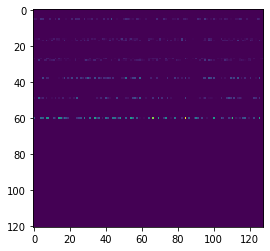

In [65]:
plt.imshow(gcn_outs[0][handle].cpu().detach().numpy())

In [66]:
gcn_outs[0][handle].cpu().detach().numpy().sum(1).nonzero()

(array([ 5, 16, 17, 27, 28, 38, 49, 60], dtype=int64),)

In [34]:
from scipy.sparse.csgraph import connected_components
simulation_num = 0
timestep = 0

cnnx_mat = np.zeros((env.number_of_agents, env.number_of_agents))
for handle, nghbr_handles in env.obs_builder.neighbors.items():
    cnnx_mat[handle, handle] = 1
    if nghbr_handles:
        for nghbr_handle in nghbr_handles:
            cnnx_mat[handle, nghbr_handle] = 1
            cnnx_mat[nghbr_handle, handle] = 1
cnnx_mat = csr_matrix(cnnx_mat)
_, labels = connected_components(csgraph=cnnx_mat, directed=False, return_labels=True)
labels
        

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  8,  6,  9, 10, 11, 11,  8,  6,
       12, 13, 14, 15, 16, 17, 15,  3, 18, 16, 11, 19, 13,  8, 20, 21,  7,
       22, 23, 16,  4, 24, 11, 16, 11, 25, 10, 19, 11, 12, 26, 27, 24])

In [39]:
feature_tens.shape, support_tens.shape

(torch.Size([50, 121, 24]), torch.Size([50, 121, 121]))